In [24]:
import os
import time
from pprint import pprint
from copy import deepcopy as dc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

mps:0 사용 가능합니다
Close          float64
MA5            float64
MA20           float64
MA60           float64
RSI14          float64
std            float64
upperb         float64
lowerb         float64
%K             float64
%D             float64
SP500          float64
NASDAQ_COMP    float64
dtype: object
                 Close         MA5        MA20        MA60      RSI14  \
Date                                                                    
2011/07/21    3.675000    3.543000    3.782250    4.299750  40.927948   
2011/07/22    3.750000    3.588000    3.767125    4.281833  45.013998   
2011/07/25    3.690000    3.636000    3.754875    4.262042  42.482342   
2011/07/26    3.600000    3.645000    3.742250    4.238708  38.944195   
2011/07/27    3.465000    3.636000    3.721750    4.214250  34.326053   
...                ...         ...         ...         ...        ...   
2021/07/14  198.414993  201.113998  196.027248  169.003166  60.429947   
2021/07/15  189.662506  199.241000  19

In [4]:
ms_x, ms_y = MinMaxScaler(), MinMaxScaler()
ss = StandardScaler()

split = int(len(data) * 0.9)
X_train = data[:split]
X_test = data[split:]
y_train = data[['Close']][:split]
y_test = data[['Close']][split:]

ms_x.fit(X_train)
X_train = ms_x.transform(X_train)
X_test = ms_x.transform(X_test)

ms_y.fit(y_train)
y_train = ms_y.transform(y_train)
y_test = ms_y.transform(y_test)

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (2264, 12) (2264, 1)
Testing Shape : (252, 12) (252, 1)


In [5]:
len_column = 12

X_train = X_train.reshape((-1, len_column, 1))
X_test = X_test.reshape((-1, len_column, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2264, 12, 1), (252, 12, 1), (2264, 1), (252, 1))

In [6]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2264, 12, 1]),
 torch.Size([252, 12, 1]),
 torch.Size([2264, 1]),
 torch.Size([252, 1]))

In [7]:
# sequence_length = 40

# data_X = []
# data_y = []
# for i in range(len(y_train) - sequence_length):
#     _X = X_train[i : i + sequence_length]  # 다음 날 종가 (i+windows_size)는 포함되지 않음
#     _y = y_train[i + sequence_length]      # 다음 날 종가
#     data_X.append(_X)
#     data_y.append(_y)
#     print(f"{_X} -> {_y}")

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [9]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_loader)

In [10]:
for _, batch in enumerate(train_loader):
    # print(batch)
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 12, 1]) torch.Size([16, 1])


In [11]:
class LSTM(nn.Module):
    def __init__(self,  input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [12]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [13]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [14]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.049

Val Loss: 0.676
***************************************************

Epoch: 2
Batch 100, Loss: 0.008

Val Loss: 0.282
***************************************************

Epoch: 3
Batch 100, Loss: 0.003

Val Loss: 0.312
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.342
***************************************************

Epoch: 5
Batch 100, Loss: 0.002

Val Loss: 0.315
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.277
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.250
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.210
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.178
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.147
********************************

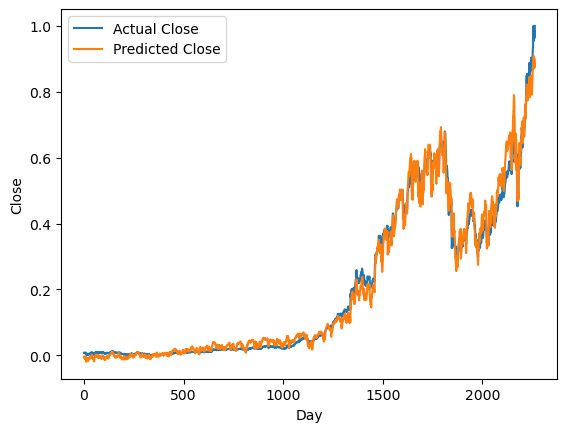

In [18]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [29]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], len_column))
dummies[:, 0] = train_predictions
dummies = ms_x.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

[[2.27737486e+00 2.88500000e+00 2.97062500e+00 ... 1.73041404e+00
  1.09922998e+03 2.33583008e+03]
 [2.54766573e+00 2.88500000e+00 2.97062500e+00 ... 1.73041404e+00
  1.09922998e+03 2.33583008e+03]
 [2.39356842e+00 2.88500000e+00 2.97062500e+00 ... 1.73041404e+00
  1.09922998e+03 2.33583008e+03]
 ...
 [9.21807387e+01 2.88500000e+00 2.97062500e+00 ... 1.73041404e+00
  1.09922998e+03 2.33583008e+03]
 [9.23727169e+01 2.88500000e+00 2.97062500e+00 ... 1.73041404e+00
  1.09922998e+03 2.33583008e+03]
 [9.47083825e+01 2.88500000e+00 2.97062500e+00 ... 1.73041404e+00
  1.09922998e+03 2.33583008e+03]]


array([ 2.27737486,  2.54766573,  2.39356842, ..., 92.18073868,
       92.37271687, 94.70838249])

In [30]:
dummies = np.zeros((X_train.shape[0], len_column))
dummies[:, 0] = y_train.flatten()
dummies = ms_y.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  3.67499999,   3.75000005,   3.69      , ..., 101.34750241,
       102.01500089, 105.107498  ])

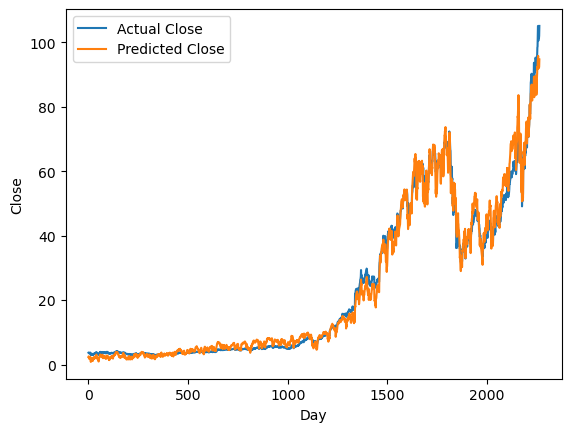

In [31]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [32]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], len_column))
dummies[:, 0] = test_predictions
dummies = ms_x.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 93.49119588,  94.21983041,  89.9184729 ,  89.21041616,
        91.03160021,  88.93186004,  91.86846325,  93.38438149,
        94.92557093,  97.2767918 ,  98.8112642 ,  99.48871024,
       100.45589122,  99.14612888,  98.72514952,  95.80422348,
        99.52609893,  99.05393107, 100.30772618, 102.23544423,
       102.59111834, 102.02937366, 102.02180327, 103.66371177,
       104.26792864, 104.98126393, 105.73799789, 105.1754852 ,
       106.68457668, 106.89640124, 108.12925282, 108.87330852,
       102.6820727 ,  99.73365676,  93.83035166,  96.65826313,
        94.16773981,  93.6156745 ,  96.35973874,  97.77880235,
        96.33446754,  95.37968445,  93.38174831,  94.18584291,
        95.23954085,  93.01715066,  94.97724705,  99.13619351,
       101.82443681, 103.15994578, 104.53012492, 104.86791536,
       101.87054181, 104.75590776, 103.70689102, 105.84339816,
       105.72737984, 106.01873613, 107.96559349, 108.29750803,
       107.79294965, 106.7552702 , 105.12607653, 101.47

In [33]:
dummies = np.zeros((X_test.shape[0], len_column))
dummies[:, 0] = y_test.flatten()
dummies = ms_y.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([103.28500346, 104.38749444, 101.29750251, 101.94500224,
       104.21499688, 102.1549982 , 104.65499974, 106.13999642,
       106.14749367, 110.10250292, 112.2774959 , 112.86749849,
       113.35500217, 111.99500221, 111.6500071 , 108.49999456,
       114.40249508, 114.42999716, 115.64000349, 123.37000281,
       122.60750268, 121.38500094, 121.41000394, 126.8349971 ,
       127.20249613, 127.4999965 , 127.7299973 , 126.28250512,
       131.47749748, 133.74499304, 138.2100099 , 143.4649924 ,
       130.15499593, 126.22500187, 119.13000079, 127.15000324,
       123.11749809, 121.64500291, 128.72249824, 129.91000064,
       125.14499653, 124.63500111, 121.89249727, 125.17249861,
       126.37750678, 121.23750639, 123.47999895, 128.73750491,
       130.35000959, 132.25750337, 135.30499264, 136.14500086,
       130.62249477, 136.42500766, 137.36500351, 139.63999632,
       138.38749342, 137.62750456, 142.25999642, 142.48249998,
       140.95250155, 139.69999865, 138.11500824, 134.97

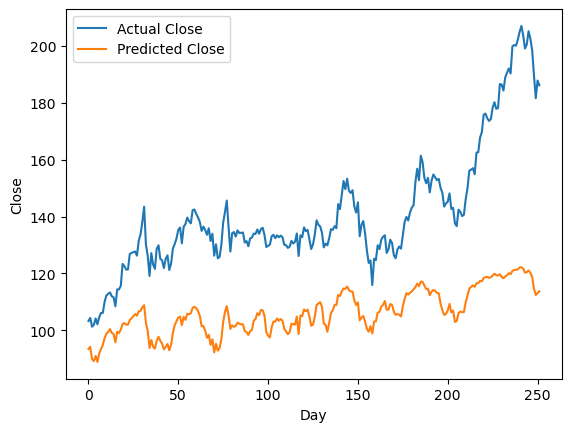

In [34]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [41]:
from torchmetrics import Accuracy

y_true = torch.tensor(new_y_test)
y_pred = torch.tensor(test_predictions)

accuracy = Accuracy()
accuracy(y_pred, y_true)

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'